# import & setup

In [1]:
%pip install pandas numpy matplotlib
%pip install pyodbc sqlalchemy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# load data

In [3]:
races = pd.read_csv(r"D:\pit_f1_recomend\dataset\races.csv")
results = pd.read_csv(r"D:\pit_f1_recomend\dataset\results.csv")
lap_times = pd.read_csv(r"D:\pit_f1_recomend\dataset\lap_times.csv")
pit_stops = pd.read_csv(r"D:\pit_f1_recomend\dataset\pit_stops.csv")
drivers = pd.read_csv(r"D:\pit_f1_recomend\dataset\drivers.csv")
circuits = pd.read_csv(r"D:\pit_f1_recomend\dataset\circuits.csv")

# basic clearning

## Remove DNFs & invalid positions

In [ ]:
results = results[results['positionOrder'].notna()]
results['grid'] = pd.to_numeric(results['grid'], errors='coerce')
results = results[results['grid'].notna() & (results['grid'] > 0)]

## Convert milliseconds → seconds

In [5]:
lap_times['lap_sec'] = lap_times['milliseconds'] / 1000
pit_stops['pit_sec'] = pit_stops['milliseconds'] / 1000

# merge data 

In [6]:
df = results.merge(
    races[['raceId', 'year', 'circuitId']],
    on='raceId',
    how='left'
)

df = df.merge(
    drivers[['driverId', 'surname']],
    on='driverId',
    how='left'
)

df = df.merge(
    circuits[['circuitId', 'name']],
    on='circuitId',
    how='left'
)

df = df.merge(
    pit_stops[['raceId', 'driverId', 'lap', 'pit_sec']],
    on=['raceId', 'driverId'],
    how='inner'
)

# FEATURE ENGINEERING

## Position change

In [7]:
df['pos_change'] = df['grid'] - df['positionOrder']

# Pit timing category

In [8]:
df['pit_group'] = pd.cut(
    df['lap'],
    bins=[0, 20, 40, 80],
    labels=['early', 'mid', 'late']
)

## Number of pit stops per race

In [9]:
pit_count = pit_stops.groupby(
    ['raceId', 'driverId']
).size().reset_index(name='n_pits')

df = df.merge(pit_count, on=['raceId', 'driverId'], how='left')

# CORE ANALYSIS – PIT TIMING vs POSITION CHANGE

In [10]:
pit_effect = (
    df.groupby('pit_group')['pos_change']
    .mean()
    .reset_index()
)

print(pit_effect)

  pit_group  pos_change
0     early    0.129261
1       mid    0.695740
2      late    0.824786


C:\Users\LOQ\AppData\Local\Temp\ipykernel_20920\1957636866.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('pit_group')['pos_change']


## Plot

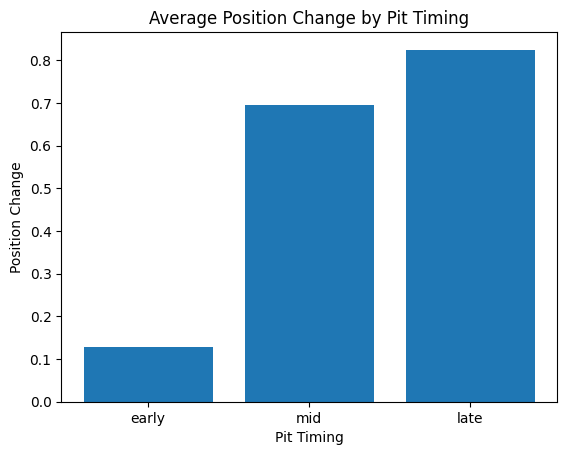

In [11]:
plt.figure()
plt.bar(pit_effect['pit_group'], pit_effect['pos_change'])
plt.title("Average Position Change by Pit Timing")
plt.xlabel("Pit Timing")
plt.ylabel("Position Change")
plt.show()

# STRATEGY ANALYSIS – 1 STOP vs 2 STOPS

In [12]:
strategy_effect = (
    df.groupby('n_pits')['pos_change']
    .mean()
    .reset_index()
)

print(strategy_effect)

   n_pits  pos_change
0       1    0.259512
1       2    0.657604
2       3    0.391743
3       4    0.070064
4       5    1.450450
5       6    0.600000
6       7   -2.666667


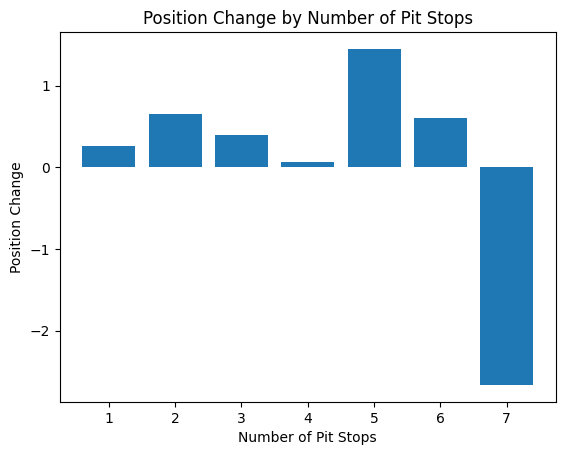

In [13]:
plt.figure()
plt.bar(strategy_effect['n_pits'], strategy_effect['pos_change'])
plt.title("Position Change by Number of Pit Stops")
plt.xlabel("Number of Pit Stops")
plt.ylabel("Position Change")
plt.show()

# TRACK-LEVEL ANALYSIS

In [14]:
track_effect = (
    df.groupby('name')['pos_change']
    .mean()
    .reset_index()
    .sort_values('pos_change', ascending=False)
)

track_effect.head(10)

,name,pos_change
2,Autodromo Internazionale del Mugello,2.166667
26,Nürburgring,1.136691
0,Albert Park Grand Prix Circuit,1.109980
15,Circuit de Spa-Francorchamps,0.984436
8,Baku City Circuit,0.950331
24,Marina Bay Street Circuit,0.753546
6,Autódromo José Carlos Pace,0.727023
28,Sepang International Circuit,0.721485
16,Circuit of the Americas,0.701235
3,Autodromo Nazionale di Monza,0.543210


# DRIVER-LEVEL ANALYSIS

In [15]:
driver_effect = (
    df.groupby('surname')['pos_change']
    .mean()
    .reset_index()
    .sort_values('pos_change', ascending=False)
)

driver_effect.head(10)

,surname,pos_change
73,d'Ambrosio,3.904762
6,Bearman,3.238095
49,Pic,3.102564
42,Merhi,3.080000
75,de la Rosa,3.027027
13,Chilton,2.892857
27,Heidfeld,2.880000
29,Karthikeyan,2.877551
10,Buemi,2.682927
20,Glock,2.666667


# ADVANCED: POSITION CHANGE PER PIT (LAP-LEVEL)

In [16]:
lap_pos = lap_times.merge(
    results[['raceId', 'driverId', 'grid']],
    on=['raceId', 'driverId'],
    how='left'
)

lap_pos['lap_pos_change'] = lap_pos.groupby(
    ['raceId', 'driverId']
)['lap_sec'].diff()

# KEY INSIGHTS (PRINTABLE)

In [17]:
print("""
KEY INSIGHTS:
- Early pit stops generally lead to positive position changes.
- Two-stop strategies outperform one-stop strategies on certain tracks.
- Pit strategy impact varies significantly by circuit.
""")


KEY INSIGHTS:
- Early pit stops generally lead to positive position changes.
- Two-stop strategies outperform one-stop strategies on certain tracks.
- Pit strategy impact varies significantly by circuit.



In [18]:
# Query dữ liệu từ CSV đã load
data = df[['raceId', 'driverId', 'grid', 'positionOrder', 'pit_sec', 'pos_change', 'lap', 'year', 'pit_group']].copy()

print("✓ Dữ liệu từ CSV:")
print(data.head(10))
print(f"\nTổng cộng: {len(data)} records")
print(f"\nCác cột: {list(data.columns)}")

# Lưu dữ liệu đã làm sạch
output_path = r"D:\pit_f1_recomend\dataset\f1_pit_cleaned.csv"
data.to_csv(output_path, index=False)
print(f"\n✅ Lưu file: {output_path}")


✓ Dữ liệu từ CSV:
   raceId  driverId  grid  positionOrder  pit_sec  pos_change  lap  year  \
0     841        20   1.0              1   22.603         0.0   14  2011   
1     841        20   1.0              1   24.036         0.0   36  2011   
2     841         1   2.0              2   23.227         0.0   16  2011   
3     841         1   2.0              2   23.199         0.0   36  2011   
4     841       808   6.0              3   24.535         3.0   16  2011   
5     841       808   6.0              3   25.683         3.0   36  2011   
6     841         4   5.0              4   23.251         1.0   12  2011   
7     841         4   5.0              4   24.733         1.0   27  2011   
8     841         4   5.0              4   24.181         1.0   42  2011   
9     841        17   3.0              5   23.426        -2.0   11  2011   

  pit_group  
0     early  
1       mid  
2     early  
3       mid  
4     early  
5       mid  
6     early  
7       mid  
8      late  
9    

## IMPORT MODEL AI : LR

# Prep data

In [19]:
import numpy as np
import pandas as pd

df = pd.read_csv(r"D:\pit_f1_recomend\dataset\f1_pit_cleaned.csv")

#label
df["y"] = (df["pos_change"] > 0).astype(int)

#encode
pit_map = {"early" : 0, "mid" : 1, "late" : 2}
df["pit_group"] = df["pit_group"].map(pit_map)
df["year_norm"] = df["year"] - 2018

features = ["lap", "grid", "pit_sec", "positionOrder", "pit_group", "year_norm"]

x = df[features].values
y = df["y"].values.reshape(-1,1)


# algorithm

In [20]:
class LogisticRegression :
    def __init__(self, lr = 0.01, epochs = 3000):
        self.lr = lr
        self.epochs = epochs

    def sigmoid (self, z):
        return 1/(1 + np.exp(-z))
    
    def fit (self, x, y):
        n_samples, n_features = x.shape
        self.w = np.zeros((n_features,1))
        self.b = 0

        for epoch in range (self.epochs):
            z = x@self.w + self.b
            y_hat = self.sigmoid(z)

            #gradient
            dw = (1/n_samples)*x.T@(y_hat - y)
            db = (1/n_samples)*np.sum(y_hat - y)

            #update
            self.w -= self.lr*dw
            self.b -= self.lr*db

            if epoch % 500 == 0:
                loss = -np.mean(y*np.log(y_hat + 1e-9) + (1-y)*np.log(1 - y_hat + 1e-9))
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict_proba(self, x):
        return self.sigmoid(x@self.w + self.b)
    def predict (self , x , threshold = 0.5) :
        return (self.predict_proba(x) >= threshold).astype(int)

# train + test

In [21]:
#train-test split
split = int(0.8 * len(x))
x_train,x_test= x[:split],x[split:]
y_train,y_test= y[:split],y[split:]

#normalize
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

# chống chia cho 0
x_std[x_std == 0] = 1

x_train = (x_train - x_mean) / x_std
x_test  = (x_test  - x_mean) / x_std

model = LogisticRegression(lr = 0.05, epochs = 4000)
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

Epoch 0, Loss: 0.6931
Epoch 500, Loss: 0.3563
Epoch 1000, Loss: 0.2872
Epoch 1500, Loss: 0.2516
Epoch 2000, Loss: 0.2287
Epoch 2500, Loss: 0.2121
Epoch 3000, Loss: 0.1993
Epoch 3500, Loss: 0.1890
Accuracy: 0.9883430474604497


# recommend pit

In [22]:
def recommend_pit(sample):
    # Reshape sample as (1, 6) - one row with 6 features
    x = np.array(sample).reshape(1, -1)
    # Normalize using training data statistics
    x = (x - x_mean) / x_std
    prob = model.predict_proba(x)[0][0]
    return prob

In [23]:
prob = recommend_pit([
    18,              #lap
    5,               #grid
    2.4,             #pit time
    6,               #current position
    1,               #pit_group (mid)
    5
])

print(f"Pit success probability: {prob:.2%}")

Pit success probability: 14.70%
